In [1]:
import numpy as np
import jax.numpy as jnp
from catalax import Model

In [2]:
model = Model(name="Menten inhibit")

model.add_species("s1, e1")

model.add_ode("s1", "- e1 * k_cat * s1 / (s1 + K_m)")
model.add_ode("e1", "-k_d", observable=False)

model.parameters.K_m.value = 100.0
model.parameters.k_cat.value = 10.0
model.parameters.k_d.value = 0.0001

model

Model summary


Eq(x, Matrix([[s1, e1]]))

Eq(theta, Matrix([[K_m, k_cat, k_d]]))

Eq(Derivative(s1, t), -e1*k_cat*s1/(K_m + s1))

Eq(Derivative(e1, t), -k_d)

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0000,False,None,None,None,None
1,k_cat,k_cat,10.0000,False,None,None,None,None
2,k_d,k_d,0.0001,False,None,None,None,None


In [3]:
initial_conditions = [
    {"s1": 100.0, "e1": 0.1},
    {"s1": 200.0, "e1": 0.1},
    {"s1": 300.0, "e1": 0.1},
    {"s1": 400.0, "e1": 0.1},
    {"s1": 10.0, "e1": 0.1},
    {"s1": 50.0, "e1": 0.1},
    {"s1": 75.0, "e1": 0.1},
    {"s1": 100.0, "e1": 0.1},
    {"s1": 200.0, "e1": 0.1},
    {"s1": 300.0, "e1": 0.1},
    {"s1": 400.0, "e1": 0.1},
    {"s1": 10.0, "e1": 0.1},
    {"s1": 50.0, "e1": 0.1},
    {"s1": 75.0, "e1": 0.1},
    {"s1": 100.0, "e1": 0.1},
    {"s1": 200.0, "e1": 0.1},
    {"s1": 300.0, "e1": 0.1},
    {"s1": 400.0, "e1": 0.1},
    {"s1": 10.0, "e1": 0.1},
    {"s1": 50.0, "e1": 0.1},
    {"s1": 75.0, "e1": 0.1},
]

time, states = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, t0=0, t1=1000, nsteps=100, in_axes=(0, None, None),
)

states = np.random.normal(states, 2).clip(min=0)

states.shape, time.shape

((21, 100, 2), (21, 100))

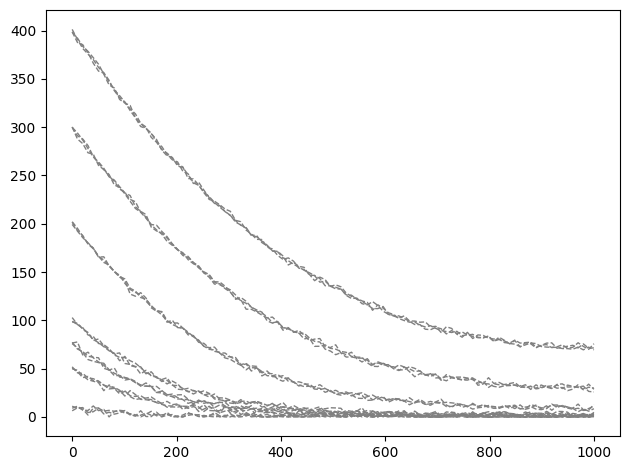

In [4]:
import matplotlib.pyplot as plt

for sp_index in range(states.shape[-1]):
    species = model.species[model._get_species_order()[sp_index]]
    
    if species.name == "e1":
        continue
    
    plt.plot(time.T, states[:, :, sp_index].T, label=species.name, c="gray", linestyle="--", linewidth=1)

plt.tight_layout()


In [5]:
# Truncate data to only include s1
data = states[:, :, 1]

In [6]:
# Set up MCMC sampling
from catalax.mcmc import run_mcmc, priors

# Define Priors
model.parameters.k_cat.prior = priors.TruncatedNormal(mu=10.0, sigma=5.0, low=5.0, high=30.0)
model.parameters.K_m.prior = priors.TruncatedNormal(mu=100.0, sigma=10.0, low=10.0, high=1000.0)
model.parameters.k_d.prior = priors.Uniform(low=1e-5, high=9e-3)

mcmc, _ = run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=time,
    yerrs=0.97,
    num_warmup=1000,
    num_samples=1000,
    dt0=1.0,
    dense_mass=True,
    max_steps=63**4,
)

<<< Priors >>>

K_m: N(μ=100.0, σ=10.0, high=1000.0 low=10.0)
k_cat: N(μ=10.0, σ=5.0, high=30.0 low=5.0)
k_d: U(low=1e-05, high=0.009)

<<< Running MCMC >>>



sample: 100%|██████████| 2000/2000 [03:34<00:00,  9.33it/s, 15 steps of size 2.28e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    100.35      0.53    100.35     99.44    101.21    516.36      1.00
     k_cat     10.00      0.02     10.00      9.97     10.03    501.24      1.01
       k_d      0.00      0.00      0.00      0.00      0.00    893.38      1.01
     sigma      1.85      0.03      1.85      1.80      1.90    479.81      1.00

Number of divergences: 0


array([<Axes: title={'center': 'K_m'}>, <Axes: title={'center': 'k_cat'}>,
       <Axes: title={'center': 'k_d'}>], dtype=object)

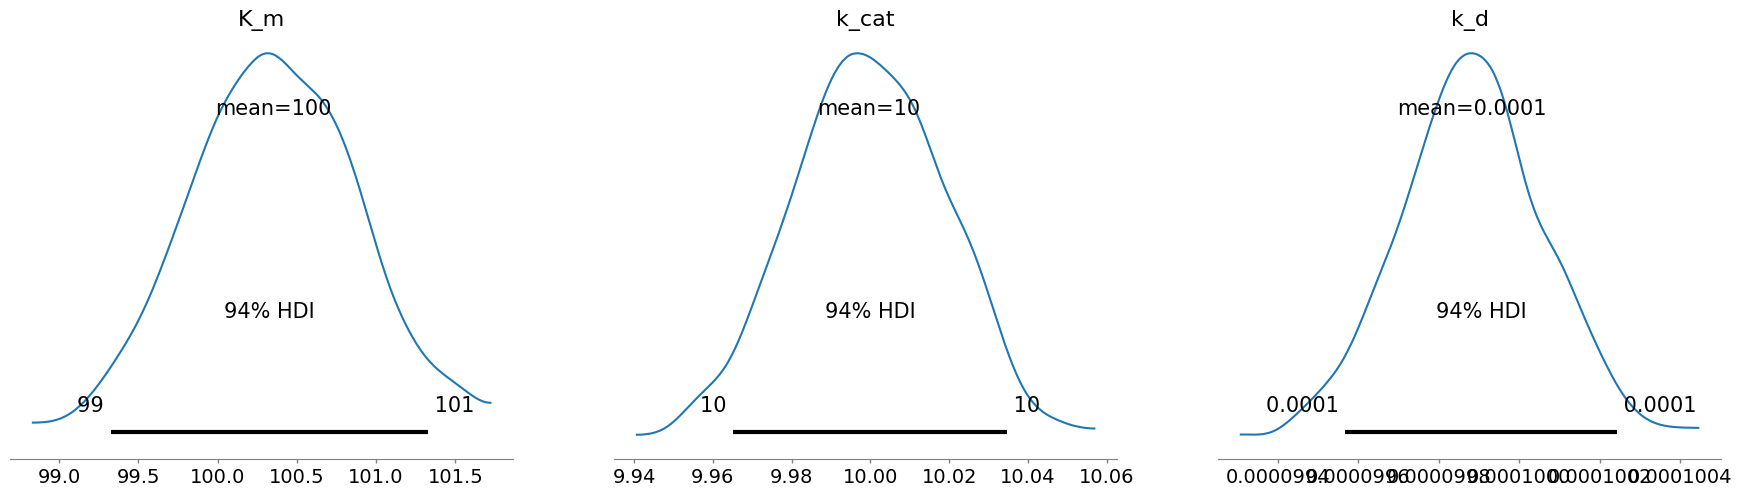

In [7]:
from catalax.mcmc import plot_posterior

plot_posterior(mcmc, model)